In [17]:
%pylab inline
import Pk_library as PKL
import MAS_library as MASL
import h5py

Populating the interactive namespace from numpy and matplotlib


/home/arodriguez/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['exp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [18]:
smooth = 0
masa = '2e-03'
path = '/home/arodriguez/BACCO/bias-voids/voids/redshift_space/540/correlations/'
sim = np.load(path+'xi_smu_galposz_RedSample_'+masa+'_'+str(smooth)+'.npy')
exp = np.load(path+'/voids_simu/xi_smu_rhogalz_'+masa+'_eul_bias_expansion_'+str(smooth)+'.npy')
gau = np.load(path+'/voids_simu/xi_smu_rhogalz_'+masa+'_eul_bias_gaus_'+str(smooth)+'.npy')

In [19]:
xir_sim = np.mean(sim,axis=0)
xir_exp = np.mean(exp,axis=0)
xir_gau = np.mean(gau,axis=0)

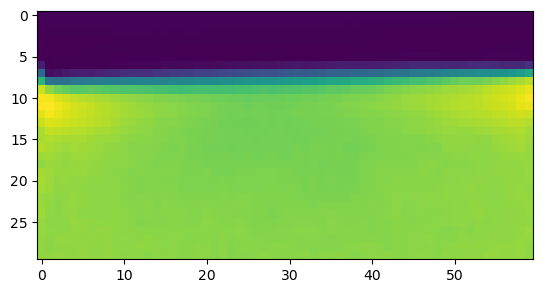

In [20]:
plt.imshow(xir_sim)

In [21]:
def P2(mu):
    polinomio = (3*(mu**2) -1)/2
    #polinomio = mu
    return polinomio

In [22]:
xir = xir_exp

bines_mu = xir.shape[1]
bines_s = xir.shape[0]

nmues = np.linspace(-1,1,bines_mu + 1)
mues = np.zeros(len(nmues)-1)
abin_mu = nmues[1]-nmues[0]
for i in range(len(nmues)-1):
    mues[i] = nmues[i] + abin_mu/2
    
neses = np.linspace(0,4,bines_s+1)
eses = np.zeros(len(neses)-1)
abin_s = neses[1]-neses[0]
for i in range(len(neses)-1):
    eses[i] = neses[i] + abin_s/2

In [23]:
def multipoles(xir, mues, eses):
    xi0 = []
    xi2 = []
    for i in range(bines_s):
        xi0.append(np.mean(xir[i,:]))
        xi2_values = []
        for j in range(bines_mu):
            mu = mues[j]
            p2 = P2(mu)
            xi2_values.append(xir[i,j]*p2)
        
        xi2.append(np.mean(xi2_values))
        
    xi2 = (5/2)*np.array(xi2)
    xi0 = np.array(xi0)
    eses = np.array(eses)
    
    return eses, xi0, xi2

In [24]:
s, xi0_sim, xi2_sim = multipoles(xir_sim, mues, eses)
s, xi0_exp, xi2_exp = multipoles(xir_exp, mues, eses)
s, xi0_gau, xi2_gau = multipoles(xir_gau, mues, eses)

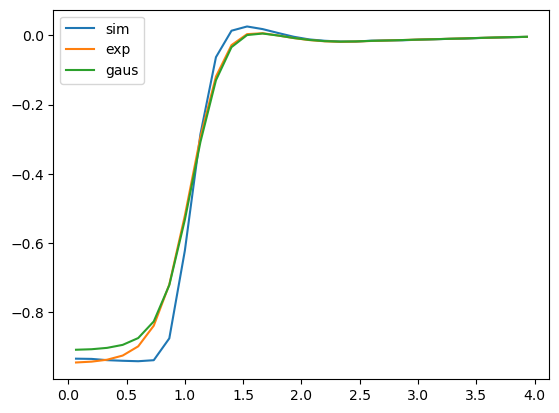

In [25]:
plt.plot(s, xi0_sim,label='sim')
plt.plot(s, xi0_exp,label='exp')
plt.plot(s,xi0_gau,label='gaus')
plt.legend()

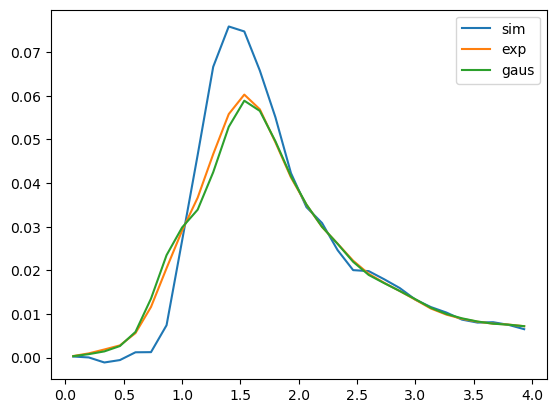

In [26]:
plt.plot(s, xi2_sim,label='sim')
plt.plot(s, xi2_exp,label='exp')
plt.plot(s,xi2_gau,label='gaus')
plt.legend()

In [27]:
sim.shape

(20106, 30, 60)

In [28]:
def multipoles(xir, mues, eses):
    xi0 = []
    xi2 = []
    for i in range(bines_s):
        xi0.append(np.mean(xir[i,:]))
        xi2_values = []
        for j in range(bines_mu):
            mu = mues[j]
            p2 = P2(mu)
            xi2_values.append(xir[i,j]*p2)
        
        xi2.append(np.mean(xi2_values))
        
    xi2 = (5/2)*np.array(xi2)
    xi0 = np.array(xi0)
    eses = np.array(eses)
    
    return xi0, xi2

In [29]:
def jacknife_maps(mapas,realizaciones):
    
    nvoids = mapas.shape[0]
    ndivision = int(nvoids/realizaciones)
    
    bines_mu = mapas.shape[2]
    bines_s = mapas.shape[1]

    nmues = np.linspace(-1,1,bines_mu + 1)
    mues = np.zeros(len(nmues)-1)
    abin_mu = nmues[1]-nmues[0]
    for i in range(len(nmues)-1):
        mues[i] = nmues[i] + abin_mu/2
    
    neses = np.linspace(0,4,bines_s+1)
    eses = np.zeros(len(neses)-1)
    abin_s = neses[1]-neses[0]
    for i in range(len(neses)-1):
        eses[i] = neses[i] + abin_s/2
        
    ##########################################################
    
    xi0_calc = np.zeros([bines_s, realizaciones])
    xi2_calc = np.zeros([bines_s, realizaciones])
    
    total_ids = np.arange(0,nvoids)
    exclude0 = 0
    for i in range(realizaciones):
        exclude1 = exclude0 + ndivision
        # selecciono (excluyo) los indices para hacer el jacknife
        selection = total_ids[(total_ids < exclude0) | (total_ids > exclude1)]
        
        xir = np.mean(mapas[selection,:,:], axis = 0)
        xi0_calc[:,i], xi2_calc[:,i] = multipoles(xir, mues, eses)
        
        exclude0 = exclude1    
    
    # xi0_calc tiene dim
    xi0_mean = np.zeros(bines_s)
    xi0_error = np.zeros(bines_s)
    xi2_mean = np.zeros(bines_s)
    xi2_error = np.zeros(bines_s)
    
    n = realizaciones
    for i in range(bines_s):
        media0 = np.mean(xi0_calc[i,:])
        error0 = np.sqrt( ((n-1)/n) * np.sum((xi0_calc[i,:]-media0)**2 ) )
        
        media2 = np.mean(xi2_calc[i,:])
        error2 = np.sqrt( ((n-1)/n) * np.sum((xi2_calc[i,:]-media2)**2 ) )
        
        
        xi0_mean[i] = media0
        xi0_error[i] = error0
        
        xi2_mean[i] = media2
        xi2_error[i] = error2
        
    return xi0_mean, xi0_error, xi2_mean, xi2_error

In [30]:
xi0_sim,xi0_sim_e, xi2_sim, xi2_sim_e = jacknife_maps(sim,50)
xi0_exp,xi0_exp_e, xi2_exp, xi2_exp_e = jacknife_maps(exp,50)
xi0_gau,xi0_gau_e, xi2_gau, xi2_gau_e = jacknife_maps(gau,50)

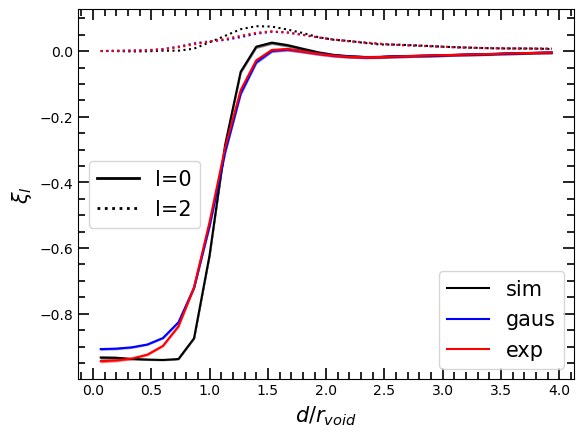

In [31]:
csimu = 'black'
cexpa = 'red'
cgaus = 'blue'

plt.plot(s,xi0_sim,label='sim',color=csimu)
plt.fill_between(s,xi0_sim-xi0_sim_e,xi0_sim+xi0_sim_e,alpha=.4,color=csimu)
plt.plot(s,xi0_gau,label='gaus',color=cgaus)
plt.fill_between(s,xi0_gau-xi0_gau_e,xi0_gau+xi0_gau_e,alpha=.4,color=cgaus)
plt.plot(s,xi0_exp,label='exp',color=cexpa)
plt.fill_between(s,xi0_exp-xi0_exp_e,xi0_exp+xi0_exp_e,alpha=.4,color=cexpa)

plt.plot(s,xi2_sim,color=csimu,ls = 'dotted')
#plt.fill_between(s,xi2_sim-xi2_sim_e,xi2_sim+xi2_sim_e,alpha=.4,color=csimu)
plt.plot(s,xi2_gau,color=cgaus,ls='dotted')
#plt.fill_between(s,xi2_gau-xi2_gau_e,xi2_gau+xi2_gau_e,alpha=.4,color=cgaus)
plt.plot(s,xi2_exp,color=cexpa,ls='dotted')
#plt.fill_between(s,xi2_exp-xi2_exp_e,xi2_exp+xi2_exp_e,alpha=.4,color=cexpa)


# Leyenda para las líneas "solid" y "dotted"
legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='l=0', linestyle='solid'),
    Line2D([0], [0], color='black', lw=2, label='l=2', linestyle='dotted')
]

# Añadir la leyenda de las líneas
plt.gca().add_artist(plt.legend(handles=legend_elements, fontsize=15, loc='center left'))



plt.legend(fontsize=15)
plt.ylabel('$\\xi_l $',size=15)
plt.xlabel('$d/r_{void}$',size=15)

plt.tick_params('both',length=5,width=1.2,which='minor',direction='in',right='on',top='on')
plt.tick_params('both',length=5,width=1.2,which='minor',direction='in',right='on',top='on')
plt.tick_params('both',length=8,width=1.2,which='major',direction='in',right='on',top='on')
#plt.tick_params(labelsize=10)
plt.minorticks_on()

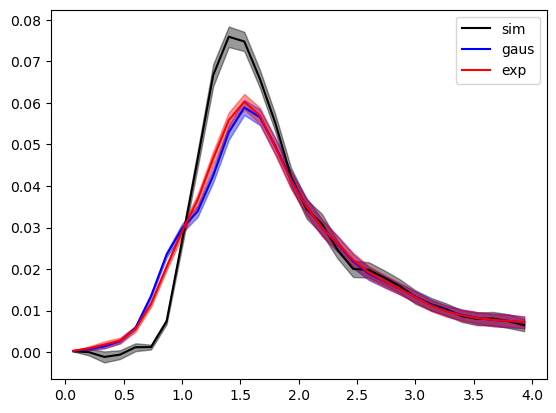

In [32]:
plt.plot(s,xi2_sim,label='sim',color=csimu)
plt.fill_between(s,xi2_sim-xi2_sim_e,xi2_sim+xi2_sim_e,alpha=.4,color=csimu)
plt.plot(s,xi2_gau,label='gaus',color=cgaus)
plt.fill_between(s,xi2_gau-xi2_gau_e,xi2_gau+xi2_gau_e,alpha=.4,color=cgaus)
plt.plot(s,xi2_exp,label='exp',color=cexpa)
plt.fill_between(s,xi2_exp-xi2_exp_e,xi2_exp+xi2_exp_e,alpha=.4,color=cexpa)
plt.legend()